In [66]:
# we need a max intensity projection to see how the 3D data looks like!

In [5]:
import matplotlib.pylab as plt
import numpy as np

import pylattice.functions.TiffProcessing as pl

Generate particle images and microscopy images
----------
**Simulation setup / Ground truth**: 
* xyz Area of 50,000 x 50,000 x 50,000 nanometers.
* 1000 particles.
* 


In [106]:
def simulate_particles(N=1000, size=50000, Damp=0.01, kamp=0.5):
    """ Simulate particles
    
    Parameters
    ----------
    N : number of particles
    size : xyz size in nanometers
    Damp : amplitude random component
    kamp : amplitude constant component
    
    """
    X = np.zeros((1, N, 3))  # particle-index, xyz
    A = np.zeros((1, N))
    # initialize
    X[0] = size * np.random.rand(N, 3)
    # simulate

    i = 0
    # constrain to bounding box
    X[i] = X[i] % size
    
    # update amplitudes
    A[i] = kamp + Damp * np.random.randn(N)

    # constrain to [0, 1]
    A[i] = np.absolute(A[i])
    A[i] = np.maximum(np.minimum(A[i], 1.0), 0.0)

    
    return X, A

In [118]:
# relationship between resolution (FWHM) and sigma
standard_resolution = 100 #nm
standard_sigma = 2*standard_resolution / (2.0 * np.sqrt(2*np.log(2)))
print("standard_sigma {}".format(standard_sigma))

standard_sigma 84.93218002880191


In [119]:
def microscope(trajs_X, trajs_A, size, 
               gridsize=100, psf_width=standard_sigma, noise_mean=0.0, noise_amp=0.1):
    """ Simulate a microscope images given a set of particles
    
    Parameters
    ----------
    trajs : numpy array (1 x N x 3)
        N particle in 3D
    size : float
        Microscope image size, in nanometers
    gridsize : float
        xyz-Size of one microscope pixel, in nanometers
    psf_width : float
        width of the point spread function, in nanometers
    noise : float
        Shot noise intensity

    
    """
    
    # make grid
    _, N, _ = trajs_X.shape
    
    ngrid = int(size / gridsize)
    c_grid = np.linspace(0, size-gridsize, num=ngrid) + 0.5*gridsize
    n_neighbors = int(3 * psf_width / gridsize) + 1
    
    print("ngrid {}".format(ngrid))
    X = np.zeros((1, ngrid, ngrid, ngrid))
    
    # spread on grid
    t=0
    for i in range(N):
        # find central grid cell
        ix = int((trajs_X[t, i, 0] / size) * ngrid)
        iy = int((trajs_X[t, i, 1] / size) * ngrid)
        iz = int((trajs_X[t, i, 2] / size) * ngrid)
        # iterate over valid neighbors
        #print(i)
        for kx in range(max(0, ix - n_neighbors), min(ngrid, ix + n_neighbors)):
            for ky in range(max(0, iy - n_neighbors), min(ngrid, iy + n_neighbors)):
                for kz in range(max(0, iz - n_neighbors), min(ngrid, iz + n_neighbors)):

                    d2 = (trajs_X[t, i, 0] - c_grid[kx])**2 + (trajs_X[t, i, 1] - c_grid[ky])**2 + (trajs_X[t, i, 2] - c_grid[kz])**2
                    value = trajs_A[t, i] * np.exp(-d2 / (2*psf_width*psf_width))
                    
                    X[t, kx, ky, kz] += value
                    
    # add noise
    noise = noise_mean + noise_amp * np.random.randn(1, ngrid, ngrid, ngrid)
    noise = np.maximum(np.minimum(noise, 1.0), 0.0)
    X += noise
    return X

In [139]:
imageSize = 50000 #50µm cube
scopeResolution = 100 #100nm resolution
numberOfParticles = 500
trajs_X, trajs_A = simulate_particles(N=numberOfParticles, size=imageSize)
#print(trajs_X)
#print(trajs_A)

In [140]:
X = microscope(trajs_X, trajs_A, size=imageSize, 
               gridsize=scopeResolution, psf_width=standard_sigma, noise_mean=0.1, noise_amp=0.0)


ngrid 500


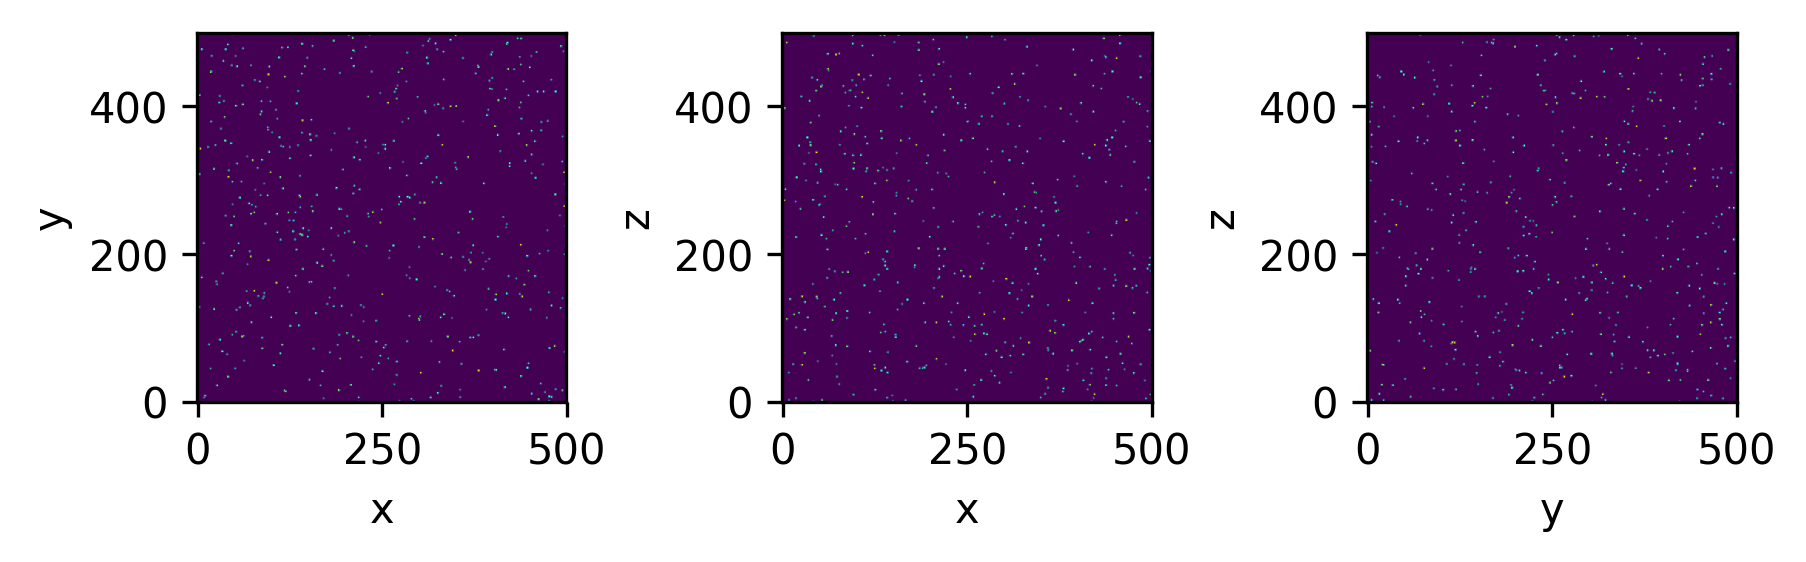

In [141]:
pl.maxIntensityProjection(X[0])

In [142]:
import skimage
import os
outputPath_tiff_prefix = './test__X_'
# this multiplier is necessary so that to prevent all the values being 0 when converting to int

multiplierForOutput = 2**16 #16 bit uint is the max value, so multiply all by that (otherwise you get 0 everywhere when converting to int)
for i in range(len(X)):
    outputPath_tiff = outputPath_tiff_prefix+str(i).zfill(2)+'.tiff'
    skimage.external.tifffile.imsave(outputPath_tiff_prefix+str(i).zfill(2)+'.tiff', (multiplierForOutput*X[i]).astype('uint16'))    
    print(os.path.abspath(outputPath_tiff))
    


#open the result in chimera X

/Users/johannesschoeneberg/git/JohSchoeneberg/pyLatticeML/src/createSimulatedData/test__X_00.tiff


In [ ]:
np.sort(multiplierForOutput*X[0].flatten())

Store data for reproducible tests
----

In [83]:
imageSize = 0.5 # microns sidelength
trajs_X, trajs_A = simulate_particles(N=2, size=imageSize, timesteps=500, D=0.025)

In [84]:

X = microscope(trajs_X, trajs_A, size=imageSize, 
#               gridsize=0.1, psf_width=standard_sigma, noise_mean=0.25, noise_amp=0.02, timestep=1)
               gridsize=0.1, psf_width=standard_sigma, noise_mean=0.25, noise_amp=0.005, timestep=1)               
Y_x4 = microscope(trajs_X, trajs_A, size=imageSize, 
                  gridsize=0.1/4, psf_width=standard_sigma/4, noise_mean=0.0, noise_amp=0.0, timestep=1)
#Y_x8 = microscope(trajs_X, trajs_A, size=imageSize, 
#                  gridsize=0.1/8, psf_width=standard_sigma/8, noise_mean=0.0, noise_amp=0.0, timestep=1)

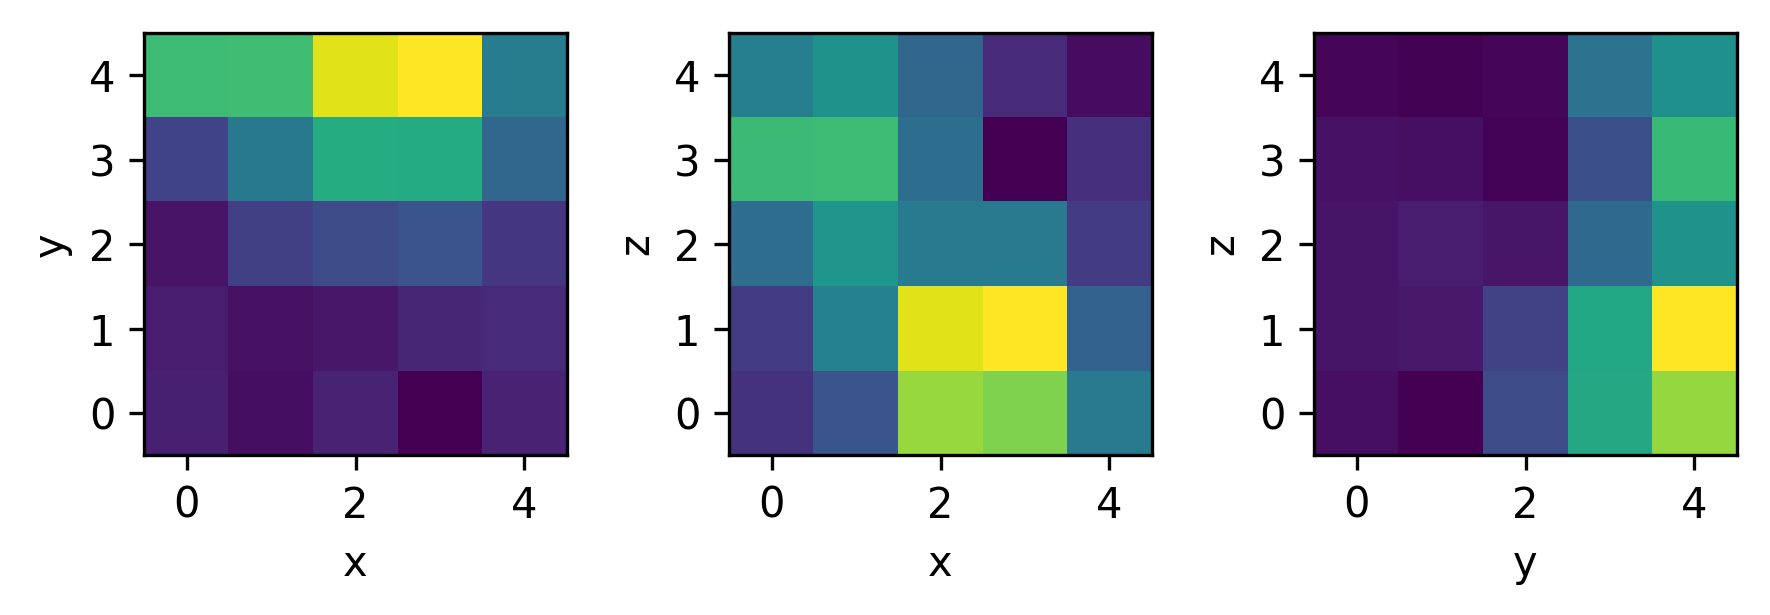

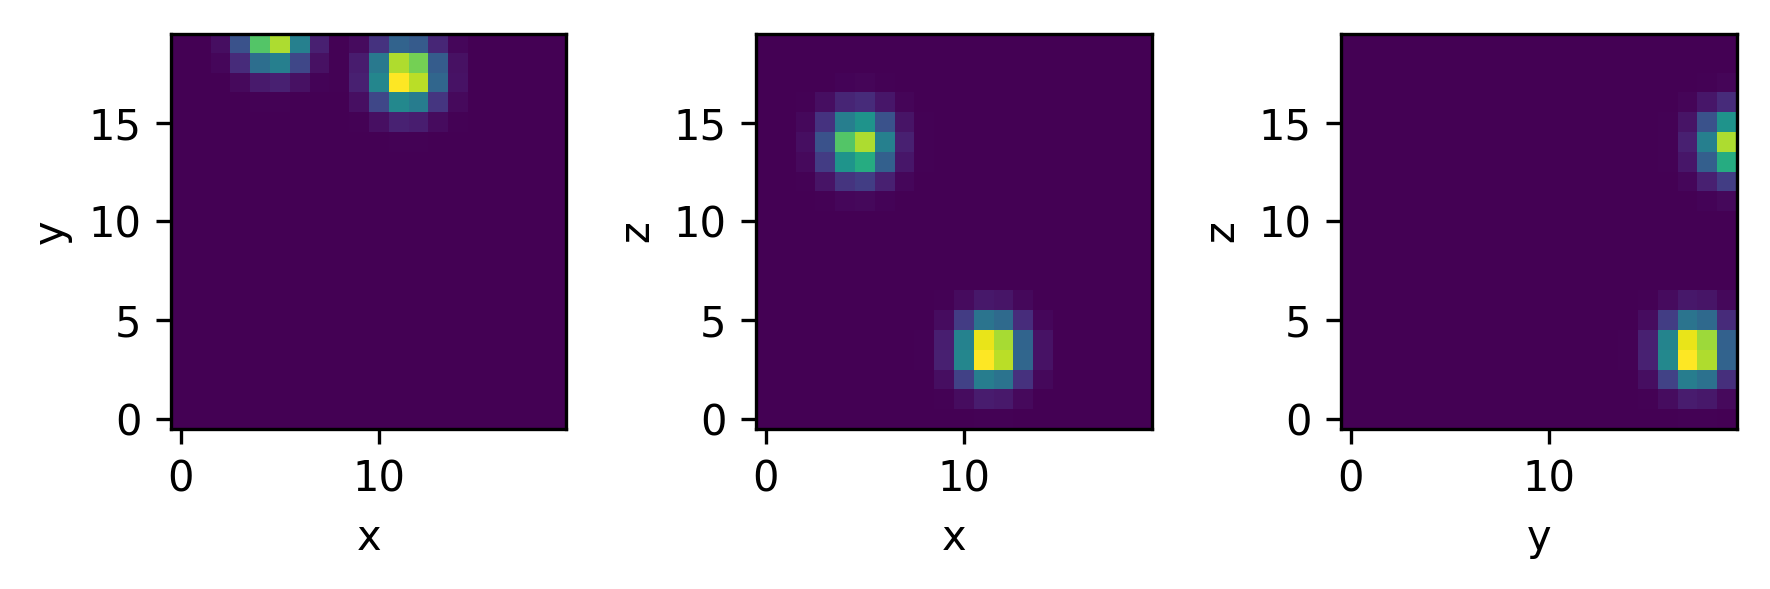

In [85]:
# interesting: the first 10 images are noise only
timepoint_looked_at = 52
pl.maxIntensityProjection(X[timepoint_looked_at])
pl.maxIntensityProjection(Y_x4[timepoint_looked_at])

In [86]:
data = {}
data['X'] = X
data['Y_x4'] = Y_x4
#data['Y_x8'] = Y_x8
np.savez_compressed('./training_data_noisy_500nm_500timepoints.npz', **data)